In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Ignore all warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
# load dataset and take a 10% random sample for development and exploration
df = pd.read_csv("/kaggle/input/los-angeles-crime-data-from-2020-to-present/Crime_Data_from_2020_to_Present.csv")
train_df = df.sample(frac=0.1, random_state=42)

#train_df.head()
#train_df.columns
#train_df.shape
#train_df.info()
#train_df.isnull().sum()

In [ ]:
# Problem Statement:
# The goal is to predict the category of a crime based on various features from the dataset,
# such as victim demographics, crime details, modus operandi, date/time, and location.
# Accurate classification of crime categories can aid law enforcement agencies in resource allocation,
# crime pattern analysis, and preventive measures.

# Project Goals:
# 1. Clean and preprocess the dataset by handling missing and inconsistent values.
# 2. Extract relevant features, including date/time components and encoded modus operandi codes.
# 3. Perform exploratory data analysis (EDA) to understand crime patterns across different dimensions.
# 4. Train and evaluate multiple classification models to predict the 'Crime Category'.
# 5. Optimize model performance through hyperparameter tuning.
# 6. Prepare a final submission file with columns "ID" (unique identifier) and "Crime Category" (predicted label).

In [3]:
# Filled missing 'Premis Cd' and 'Premis Desc' with mode to preserve data consistency.
# Dropped high-NaN or redundant columns to reduce noise and dimensionality.

# fill missing values in these columns with their most frequent value
train_df['Premis Cd'] = train_df['Premis Cd'].fillna(train_df['Premis Cd'].mode().iloc[0])
train_df['Premis Desc'] = train_df['Premis Desc'].fillna(train_df['Premis Desc'].mode().iloc[0])

# drop unnecessary and/or Nan heavy columns
remove_cols = ['DR_NO', 'Cross Street', 'Crm Cd', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4']
train_df = train_df.drop(remove_cols, axis=1)

#train_df.isnull().sum()

In [4]:
#train_df['Crm Cd Desc'].unique()
#train_df['Crm Cd'].unique()

In [5]:
# Mapped detailed crime descriptions to 6 broad categories for simplification.
# Filled unmapped entries as 'Other Crimes' to avoid data loss.

# Full mapping dictionary 
crime_mapping = {
    # Property Crimes
    'VEHICLE - STOLEN': 'Property Crimes',
    'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)': 'Property Crimes',
    'BURGLARY FROM VEHICLE': 'Property Crimes',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)': 'Property Crimes',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'Property Crimes',
    'BURGLARY, ATTEMPTED': 'Property Crimes',
    'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD': 'Property Crimes',
    'THEFT PLAIN - PETTY ($950 & UNDER)': 'Property Crimes',
    'BURGLARY': 'Property Crimes',
    'THEFT, PERSON': 'Property Crimes',
    'SHOPLIFTING - PETTY THEFT ($950 & UNDER)': 'Property Crimes',
    'BURGLARY FROM VEHICLE, ATTEMPTED': 'Property Crimes',
    'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)': 'Property Crimes',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)': 'Property Crimes',
    'BIKE - STOLEN': 'Property Crimes',
    'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)': 'Property Crimes',
    'VEHICLE - ATTEMPT STOLEN': 'Property Crimes',
    'THEFT FROM MOTOR VEHICLE - ATTEMPT': 'Property Crimes',
    'PICKPOCKET': 'Property Crimes',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER': 'Property Crimes',
    'THEFT PLAIN - ATTEMPT': 'Property Crimes',
    'SHOPLIFTING - ATTEMPT': 'Property Crimes',
    'BOAT - STOLEN': 'Property Crimes',
    'DRIVING WITHOUT OWNER CONSENT (DWOC)': 'Property Crimes',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01': 'Property Crimes',
    'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)': 'Property Crimes',
    'TILL TAP - PETTY ($950 & UNDER)': 'Property Crimes',
    'PICKPOCKET, ATTEMPT': 'Property Crimes',
    'PURSE SNATCHING': 'Property Crimes',
    'THEFT FROM PERSON - ATTEMPT': 'Property Crimes',
    'TILL TAP - GRAND THEFT ($950.01 & OVER)': 'Property Crimes',
    'DRUNK ROLL': 'Property Crimes',
    'PURSE SNATCHING - ATTEMPT': 'Property Crimes',
    'PETTY THEFT - AUTO REPAIR': 'Property Crimes',

    # Violent Crimes
    'INTIMATE PARTNER - AGGRAVATED ASSAULT': 'Violent Crimes',
    'BATTERY WITH SEXUAL CONTACT': 'Violent Crimes',
    'CRIMINAL THREATS - NO WEAPON DISPLAYED': 'Violent Crimes',
    'BATTERY - SIMPLE ASSAULT': 'Violent Crimes',
    'ROBBERY': 'Violent Crimes',
    'INTIMATE PARTNER - SIMPLE ASSAULT': 'Violent Crimes',
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': 'Violent Crimes',
    'ATTEMPTED ROBBERY': 'Violent Crimes',
    'OTHER ASSAULT': 'Violent Crimes',
    'SHOTS FIRED AT INHABITED DWELLING': 'Violent Crimes',
    'BRANDISH WEAPON': 'Violent Crimes',
    'EXTORTION': 'Violent Crimes',
    'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER': 'Violent Crimes',
    'BATTERY POLICE (SIMPLE)': 'Violent Crimes',
    'STALKING': 'Violent Crimes',
    'CRIMINAL HOMICIDE': 'Violent Crimes',
    'THREATENING PHONE CALLS/LETTERS': 'Violent Crimes',
    'BATTERY ON A FIREFIGHTER': 'Violent Crimes',
    'MANSLAUGHTER, NEGLIGENT': 'Violent Crimes',

    # Crimes against Public Order
    'VIOLATION OF COURT ORDER': 'Crimes against Public Order',
    'TRESPASSING': 'Crimes against Public Order',
    'VIOLATION OF RESTRAINING ORDER': 'Crimes against Public Order',
    'CONTEMPT OF COURT': 'Crimes against Public Order',
    'DISTURBING THE PEACE': 'Crimes against Public Order',
    'FALSE POLICE REPORT': 'Crimes against Public Order',
    'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE': 'Crimes against Public Order',
    'RECKLESS DRIVING': 'Crimes against Public Order',
    'INDECENT EXPOSURE': 'Crimes against Public Order',
    'DISCHARGE FIREARMS/SHOTS FIRED': 'Crimes against Public Order',
    'FAILURE TO YIELD': 'Crimes against Public Order',
    'CONTRIBUTING': 'Crimes against Public Order',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER': 'Crimes against Public Order',
    'PANDERING': 'Crimes against Public Order',
    'LEWD CONDUCT': 'Crimes against Public Order',
    'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT': 'Crimes against Public Order',
    'RESISTING ARREST': 'Crimes against Public Order',
    'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)': 'Crimes against Public Order',
    'LYNCHING': 'Crimes against Public Order',
    'LYNCHING - ATTEMPTED': 'Crimes against Public Order',
    'WEAPONS POSSESSION/BOMBING': 'Crimes against Public Order',
    'FIREARMS RESTRAINING ORDER (FIREARMS RO)': 'Crimes against Public Order',
    'DRUGS, TO A MINOR': 'Crimes against Public Order',
    'INCITING A RIOT': 'Crimes against Public Order',
    'PEEPING TOM': 'Crimes against Public Order',

    # Fraud and White-Collar Crimes
    'THEFT OF IDENTITY': 'Fraud and White-Collar Crimes',
    'BUNCO, GRAND THEFT': 'Fraud and White-Collar Crimes',
    'DOCUMENT FORGERY / STOLEN FELONY': 'Fraud and White-Collar Crimes',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)': 'Fraud and White-Collar Crimes',
    'BUNCO, PETTY THEFT': 'Fraud and White-Collar Crimes',
    'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)': 'Fraud and White-Collar Crimes',
    'DOCUMENT WORTHLESS ($200 & UNDER)': 'Fraud and White-Collar Crimes',
    'UNAUTHORIZED COMPUTER ACCESS': 'Fraud and White-Collar Crimes',
    'DOCUMENT WORTHLESS ($200.01 & OVER)': 'Fraud and White-Collar Crimes',
    'DISHONEST EMPLOYEE - PETTY THEFT': 'Fraud and White-Collar Crimes',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)': 'Fraud and White-Collar Crimes',
    'BUNCO, ATTEMPT': 'Fraud and White-Collar Crimes',
    'COUNTERFEIT': 'Fraud and White-Collar Crimes',
    'GRAND THEFT / AUTO REPAIR': 'Fraud and White-Collar Crimes',
    'DISHONEST EMPLOYEE - GRAND THEFT': 'Fraud and White-Collar Crimes',
    'CREDIT CARDS, FRAUD USE ($950 & UNDER': 'Fraud and White-Collar Crimes',
    'GRAND THEFT / INSURANCE FRAUD': 'Fraud and White-Collar Crimes',

    # Crimes against Persons
    'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)': 'Crimes against Persons',
    'CHILD STEALING': 'Crimes against Persons',
    'ORAL COPULATION': 'Crimes against Persons',
    'CHILD ANNOYING (17YRS & UNDER)': 'Crimes against Persons',
    'SEXUAL PENETRATION W/FOREIGN OBJECT': 'Crimes against Persons',
    'RAPE, FORCIBLE': 'Crimes against Persons',
    'RAPE, ATTEMPTED': 'Crimes against Persons',
    'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ': 'Crimes against Persons',
    'CHILD ABANDONMENT': 'Crimes against Persons',
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT': 'Crimes against Persons',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT': 'Crimes against Persons',
    'LEWD/LASCIVIOUS ACTS WITH CHILD': 'Crimes against Persons',
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH': 'Crimes against Persons',
    'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS': 'Crimes against Persons',
    'CHILD NEGLECT (SEE 300 W.I.C.)': 'Crimes against Persons',
    'FALSE IMPRISONMENT': 'Crimes against Persons',
    'KIDNAPPING - GRAND ATTEMPT': 'Crimes against Persons',
    'KIDNAPPING': 'Crimes against Persons',
    'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE': 'Crimes against Persons',
    'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)': 'Crimes against Persons',
    'CHILD PORNOGRAPHY': 'Crimes against Persons',

    # Other Crimes
    'LETTERS, LEWD - TELEPHONE CALLS, LEWD': 'Other Crimes',
    'OTHER MISCELLANEOUS CRIME': 'Other Crimes',
    'THROWING OBJECT AT MOVING VEHICLE': 'Other Crimes',
    'CRUELTY TO ANIMALS': 'Other Crimes',
    'BOMB SCARE': 'Other Crimes',
    'CONSPIRACY': 'Other Crimes',
    'ILLEGAL DUMPING': 'Other Crimes',
    'PROWLER': 'Other Crimes',
    'BIGAMY': 'Other Crimes'
}

# apply the mapping to the dataset:
train_df['Crime Category'] = train_df['Crm Cd Desc'].map(crime_mapping)

# any unmapped crimes (NaNs), assign them to 'Other Crimes'
train_df['Crime Category'] = train_df['Crime Category'].fillna('Other Crimes')

# Check unique categories assigned:
#print(train_df['Crime Category'].unique())

In [6]:
# Replaced non-positive victim ages with sex-specific median to correct invalid entries without biasing age distribution.

tab = train_df.groupby(['Vict Age', 'Vict Sex','Crime Category']).size().reset_index(name='counts')
#tab[tab['Vict Age']<=0]

median_age_by_sex= train_df.groupby( 'Vict Sex').median(numeric_only=True)['Vict Age']
#median_age_by_sex

def replace_negative_age(row):
    if row['Vict Age'] <= 0:
        return median_age_by_sex.get(row['Vict Sex'], row['Vict Age'])
    return row['Vict Age']

# replace negative values in Victim Age
train_df['Vict Age'] = train_df.apply(replace_negative_age, axis=1)

In [7]:
# Filled missing 'Mocodes' with mode for consistency.
# Split 'Mocodes' into individual codes to enable multi-label or feature extraction.
# Filtered to frequent codes (occurring >2 times) to reduce noise.

#train_df['Mocodes'].value_counts()
#train_df['Mocodes'].unique()

value_counts = train_df['Mocodes'].value_counts()
filtered_values = value_counts[value_counts > 2]
#print(filtered_values)

train_df['Mocodes'].mode()[0]
train_df['Mocodes'].fillna(train_df['Mocodes'].mode()[0],inplace=True)
train_df["Mocodes"] = train_df["Mocodes"].apply(lambda x:str(x).split(" ") if x else [])

#train_df.isnull().sum()

In [8]:
# Filled missing 'Vict Sex' using most common sex for each age, falling back to overall mode if age not found.

train_df['Vict Age'] = train_df['Vict Age'].astype(int)
train_df['Vict Sex'].value_counts()

tbl_sex = train_df.groupby(['Vict Age', 'Vict Sex']).size().reset_index(name='counts')
#tbl_sx.sample(10)

tbl_sex.groupby('Vict Age')['counts'].idxmax()

mode_sex = tbl_sex.loc[tbl_sex.groupby('Vict Age')['counts'].idxmax()]
#mode_sex

mode_sex_dict = mode_sex.set_index('Vict Age')['Vict Sex'].to_dict()
#mode_sex_dict

overall_mode_sex = train_df['Vict Sex'].mode()[0]

def fill_victim_sex(row):
    if pd.isna(row['Vict Sex']):
        return mode_sex_dict.get(row['Vict Age'], overall_mode_sex)
    return row['Vict Sex']

# fill NaN values in Victim Sex
train_df['Vict Sex'] = train_df.apply(fill_victim_sex, axis=1)

#train_df.isnull().sum()
#train_df['Vict Sex'].value_counts()
#train_df['Vict Descent'].value_counts()

In [9]:
# Computed most common 'Vict Descent' for each 'Vict Sex' to later fill missing descent values contextually.

table_descent = train_df.groupby(['Vict Descent', 'Vict Sex']).size().reset_index(name='counts')
#table_descent

mode_descent = table_descent.loc[table_descent.groupby('Vict Sex')['counts'].idxmax()]
#mode_descent

mode_descent_dict = mode_descent.set_index('Vict Sex')['Vict Descent'].to_dict()
#mode_descent_dict

In [10]:
# Fill missing 'Vict Descent' using the most common value for the corresponding 'Vict Sex'; fallback to NaN if unknown.

def fill_victim_descent(row):
    if pd.isna(row['Vict Descent']):
        # Use mode_sex_dict to determine the value for the given Victim Age
        return mode_descent_dict.get(row['Vict Sex'], np.nan)
    return row['Vict Descent']

# fill NaN values in Victim Sex
train_df['Vict Descent'] = train_df.apply(fill_victim_descent, axis=1)

#train_df.isnull().sum()
#train_df['Victim_Descent'].value_counts()

In [11]:
# Filled missing 'Weapon Desc' and 'Weapon Used Cd' with their respective modes to maintain data integrity.

train_df['Weapon Desc'].value_counts()
train_df['Weapon Desc'].fillna(train_df['Weapon Desc'].mode()[0],inplace=True)
train_df['Weapon Used Cd'].fillna(train_df['Weapon Used Cd'].mode()[0],inplace=True)

#train_df.isnull().sum()
#train_df.sample(10)

In [12]:
# Parsed date columns to datetime for accurate time-based analysis.
# Extracted year, month, day, and hour features to capture temporal crime patterns.

date_format = '%m/%d/%Y %I:%M:%S %p'  # Month/Day/Year Hour:Minute:Second AM/PM

train_df['Date Rptd'] = pd.to_datetime(train_df['Date Rptd'], format=date_format)
train_df['DATE OCC'] = pd.to_datetime(train_df['DATE OCC'], format=date_format)

train_df['Year_Reported'] = train_df['Date Rptd'].dt.year
train_df['Month_Reported'] = train_df['Date Rptd'].dt.month
train_df['Day_Reported'] = train_df['Date Rptd'].dt.day
train_df['Hour_Occurred'] = train_df['TIME OCC'].apply(lambda x: int(x // 100))

#train_df.sample(10)

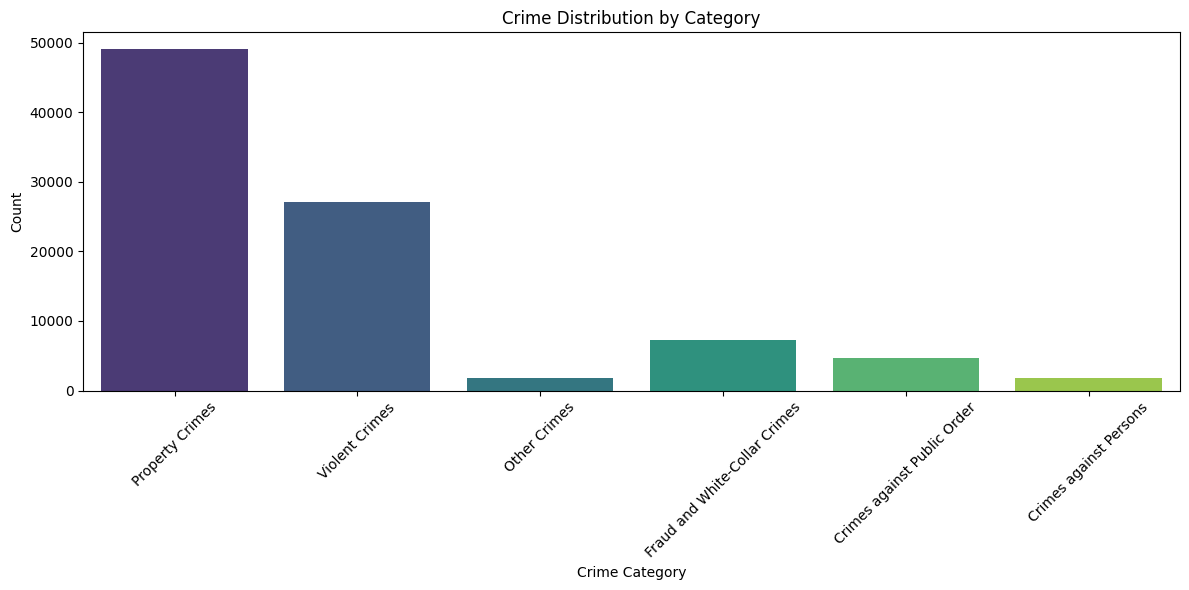

In [13]:
# Used countplot to visualize distribution of crimes by category, highlighting frequency and imbalance.
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='Crime Category', palette='viridis')
plt.title('Crime Distribution by Category')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

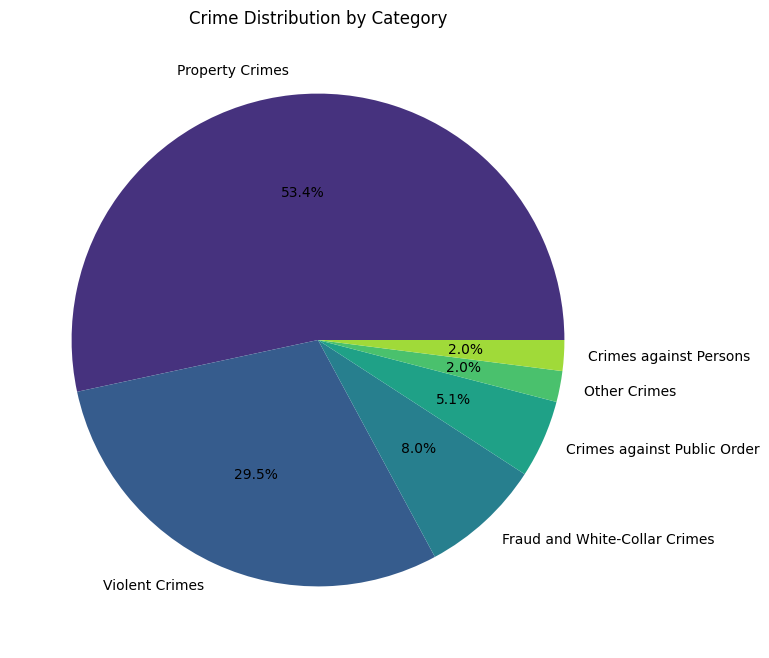

In [14]:
# Created pie chart for proportional visualization of crime categories, providing intuitive share insight.
plt.figure(figsize=(8, 8))
train_df['Crime Category'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', len(train_df['Crime Category'].unique())))
plt.title('Crime Distribution by Category')
plt.ylabel('')
plt.show()

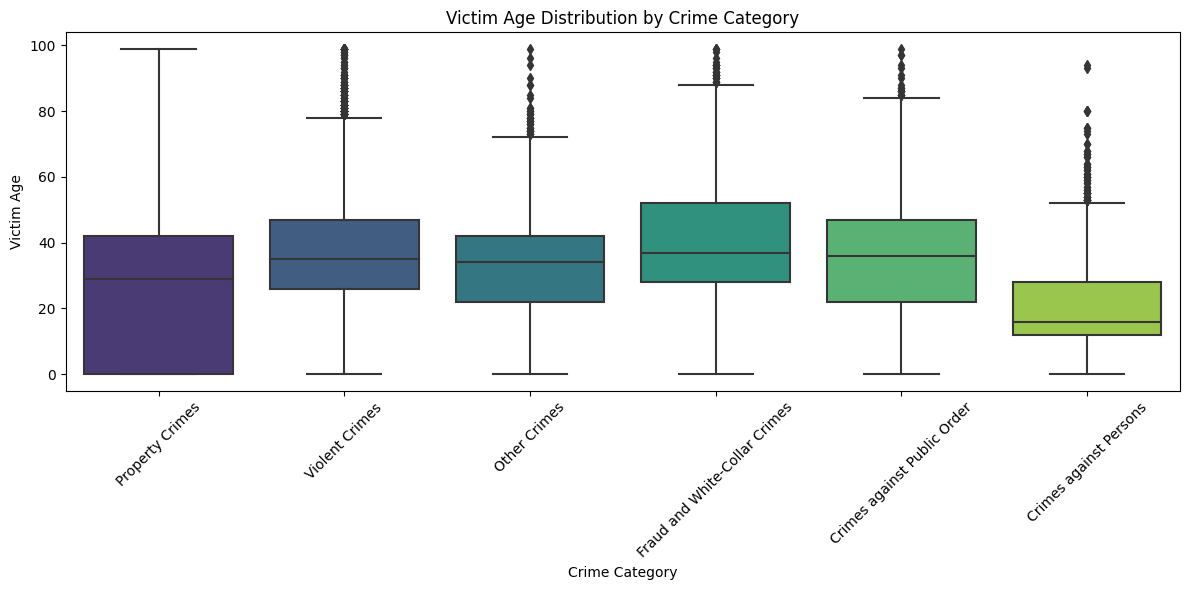

In [15]:
# Boxplot to analyze victim age spread per crime category, identifying age-related crime patterns and outliers.
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='Crime Category', y='Vict Age', palette='viridis')
plt.title('Victim Age Distribution by Crime Category')
plt.xlabel('Crime Category')
plt.ylabel('Victim Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

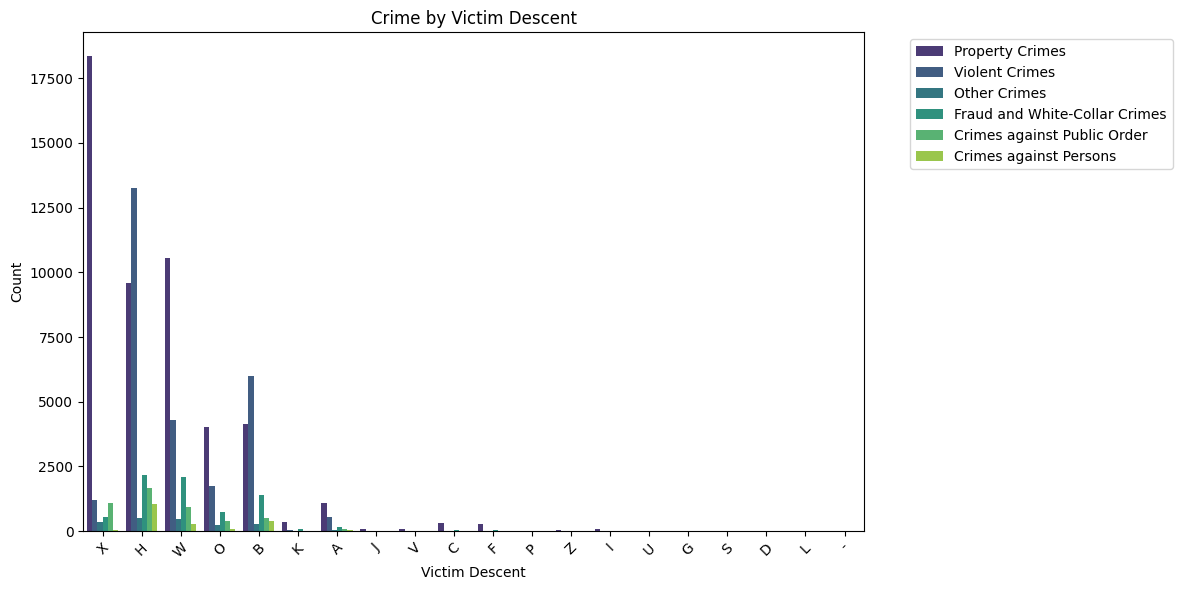

In [16]:
# Countplot showing distribution of crimes by victim descent, segmented by crime category for demographic insights.
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='Vict Descent', hue='Crime Category', palette='viridis')
plt.title('Crime by Victim Descent')
plt.xlabel('Victim Descent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

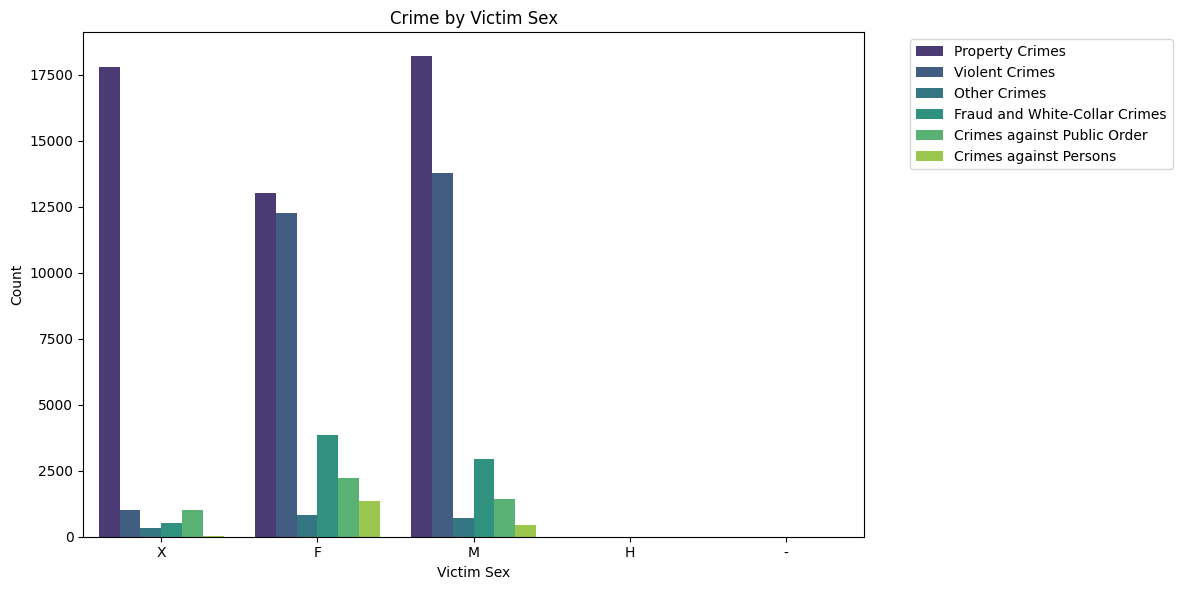

In [17]:
# Countplot displaying crime counts by victim sex, segmented by crime category for gender-based crime patterns.
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='Vict Sex', hue='Crime Category', palette='viridis')
plt.title('Crime by Victim Sex')
plt.xlabel('Victim Sex')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

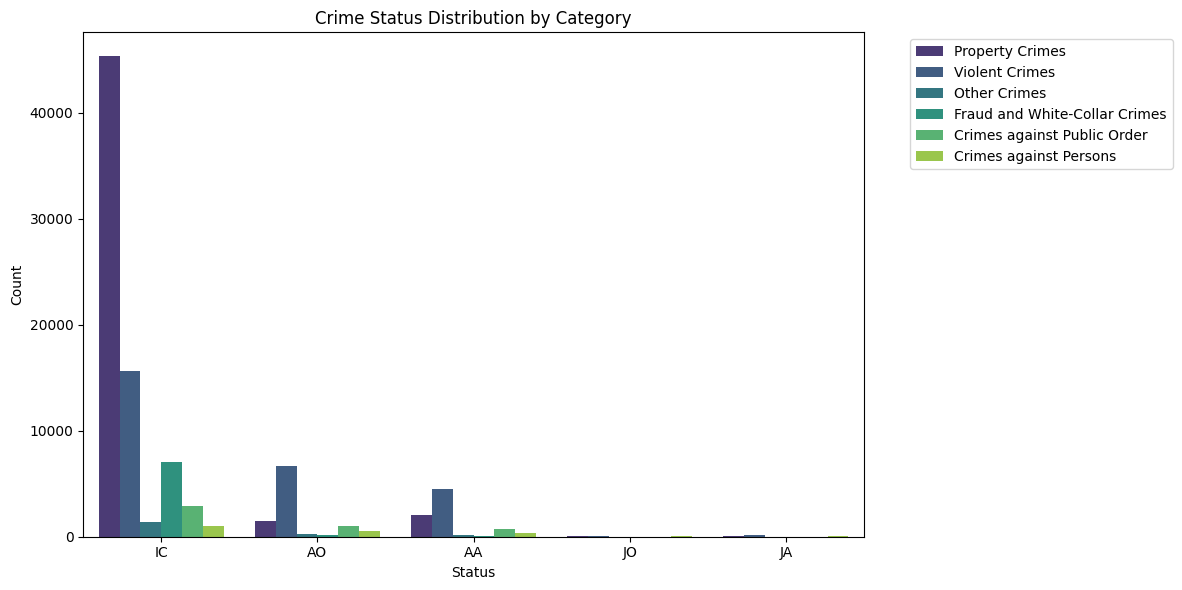

In [18]:
# Countplot showing distribution of crime 'Status' across categories to assess case resolution patterns.
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='Status', hue='Crime Category', palette='viridis')
plt.title('Crime Status Distribution by Category')
plt.xlabel('Status')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

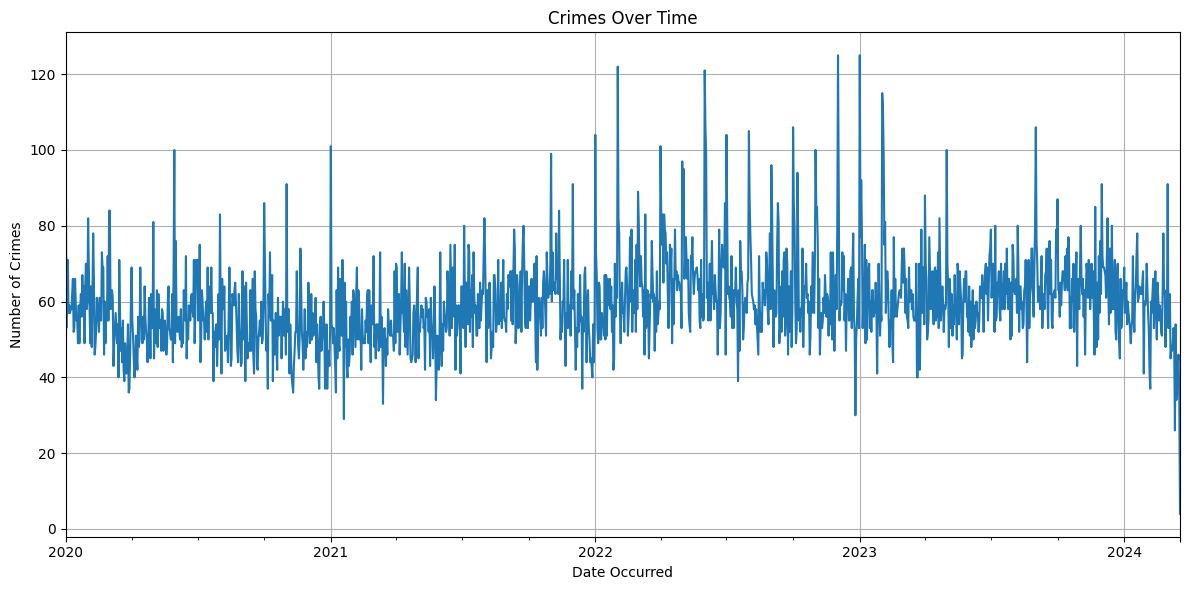

In [19]:
# Line plot tracking daily crime counts to observe trends and seasonality over time.
train_df['DATE OCC'] = pd.to_datetime(train_df['DATE OCC'])
crimes_over_time = train_df.groupby('DATE OCC').size()

plt.figure(figsize=(12, 6))
crimes_over_time.plot()
plt.title('Crimes Over Time')
plt.xlabel('Date Occurred')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

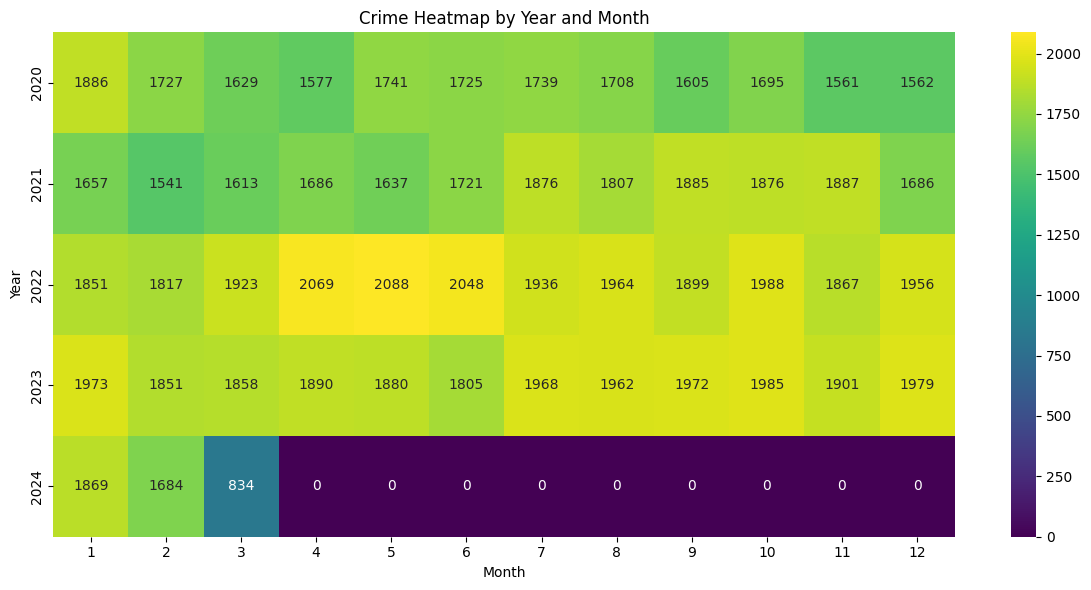

In [20]:
# Heatmap visualizing monthly crime counts per year to identify temporal patterns and seasonality.
train_df['Year_Occurred'] = train_df['DATE OCC'].dt.year
train_df['Month_Occurred'] = train_df['DATE OCC'].dt.month

heatmap_data = train_df.pivot_table(index='Year_Occurred', columns='Month_Occurred', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d')
plt.title('Crime Heatmap by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

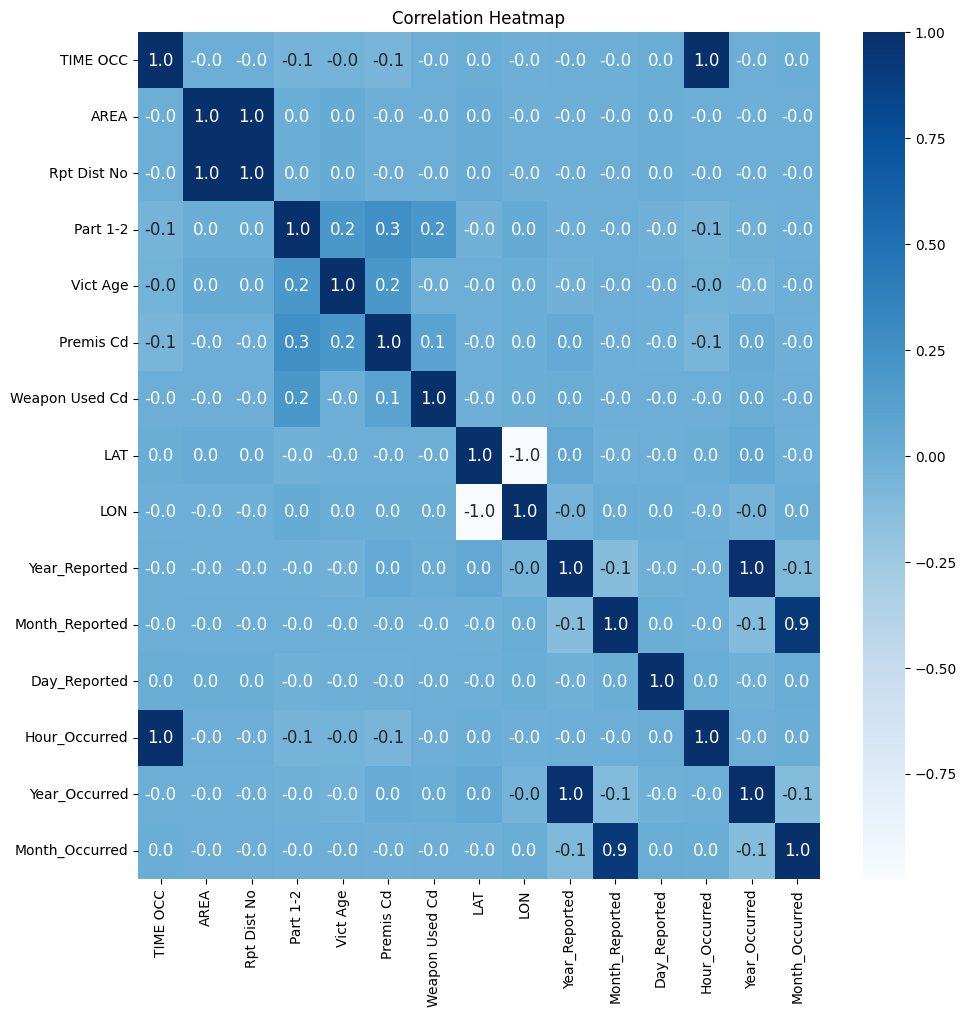

In [21]:
# Correlation heatmap of numeric features with dynamic figure size based on feature count.
def my_heatmap(df, size):
   if size: plt.figure(figsize=size)
   sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap='Blues', annot_kws={"size": 12})
   plt.title('Correlation Heatmap')
   plt.show()
    
n_numeric_cols = len(train_df.select_dtypes(include=[np.number]).columns) // 3 * 2
my_heatmap(train_df.select_dtypes(include=[np.number]), size=(n_numeric_cols+1, n_numeric_cols+1))

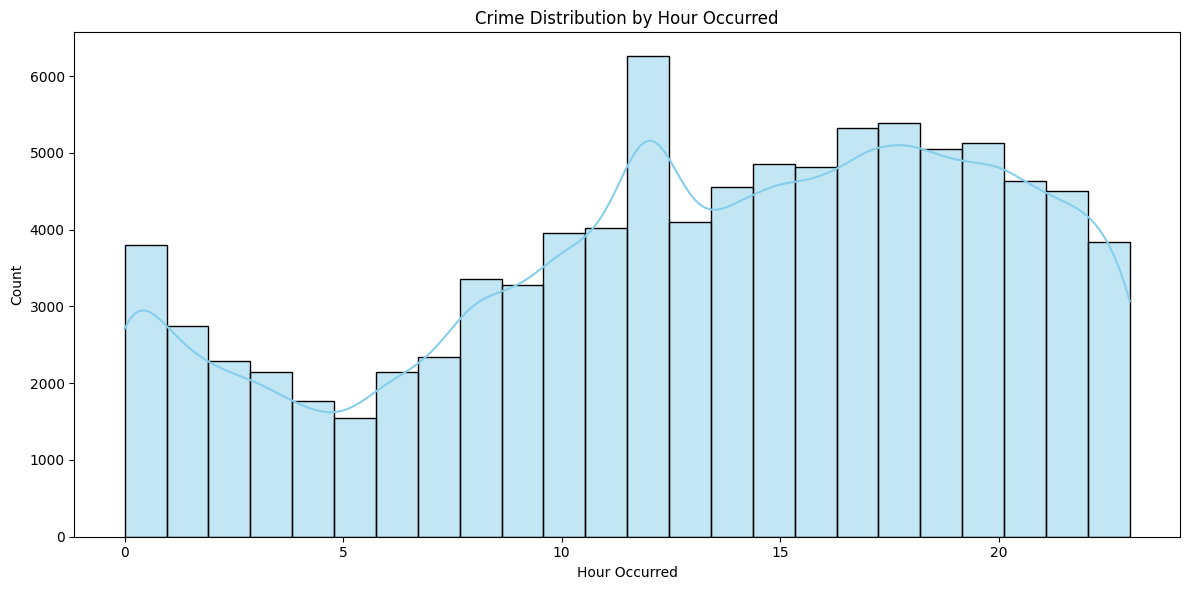

In [22]:
# Histogram of crime counts by hour of day with KDE smoothing.
plt.figure(figsize=(12, 6))
sns.histplot(train_df, x='Hour_Occurred', bins=24, kde=True, color='skyblue')
plt.title('Crime Distribution by Hour Occurred')
plt.xlabel('Hour Occurred')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [23]:
# Extract unique modus codes from cleaned 'Mocodes' strings and create corresponding column names.
# Initialize a zero-filled DataFrame with these columns for binary encoding.
train_df['Mocodes'] = train_df['Mocodes'].astype(str)

modus = pd.Series(train_df['Mocodes'])
modus = modus.dropna()

# get unique modus operandi
s = modus.unique()
word_list = []
for row in s:
    # Remove brackets and quotes from the whole string first
    cleaned_row = row.strip("[]").replace("'", "").replace('"', '')
    words = cleaned_row.split(' ')
    for w in words:
        if w:  # avoid empty strings
            word_list.append(w)

# the unique number of modus
modus_unique = set(word_list)
mu_list = list(modus_unique)
col_name_list = []
# create list of column names, clean again just in case
for i in range(0, len(mu_list)):
    clean_code = mu_list[i].strip("[]").replace("'", "").replace('"', '')
    col_name = 'Mocode_' + clean_code
    col_name_list.append(col_name)

#print(len(col_name_list))

# new dataframe with these column names
zero_data = np.zeros(shape = (len(train_df), len(col_name_list)))
train_modus = pd.DataFrame(zero_data, columns = col_name_list, dtype='int8')

In [24]:
# One-hot encode each cleaned modus operandi code into corresponding binary columns,
# then merge these new features into the original DataFrame and drop the old 'Mocodes' column.
modus_cols = train_modus.columns
zero_data = np.zeros(shape = (len(train_df), len(modus_cols)))
df_temp = pd.DataFrame(zero_data, columns = modus_cols, dtype='int8')

train_df['Mocodes'] = train_df['Mocodes'].replace({None: np.nan})
train_df['Mocodes'] = train_df['Mocodes'].replace({"": np.nan})
train_df['Mocodes'] = train_df['Mocodes'].fillna(value = 0)

for i in range(0,len(train_df)):
    m = str(train_df['Mocodes'].iloc[i])
    # Clean string by removing brackets and quotes
    cleaned_m = m.strip("[]").replace("'", "").replace('"', '')
    words = cleaned_m.split(' ')
    for w in words:
        if w != "0" and w != '':
            col = 'Mocode_' + w
            if col in modus_cols:
                df_temp.loc[i, col] = 1

# Combine new binary features with original data and drop old Mocodes column
train_df = pd.concat([train_df.reset_index(drop = True), df_temp.reset_index(drop = True)], axis=1)
train_df = train_df.drop(['Mocodes'],axis=1)

In [25]:
# Convert specified columns to integer type for consistent numerical handling.
columns_to_convert = ['AREA', 'Part 1-2', 'Premis Cd', 'Rpt Dist No', 'Weapon Used Cd']
train_df[columns_to_convert] = train_df[columns_to_convert].astype(int)

In [26]:
# Drop first row, then reset index which adds old index as 'index' column.
train_df.drop(train_df.index[0],inplace=True)
train_df.reset_index(inplace=True)

In [27]:
# Clean and prepare the dataset by removing non-informative or text-heavy columns, 
# encoding categorical labels, & transforming categorical features into numeric format for compatibility w/ models.
# Split data into 80% train and 20% test sets for modeling and evaluation.
train_df = train_df.drop(columns=['index','Crm Cd Desc', 'AREA NAME', 'LOCATION', 'Premis Desc', 'Weapon Desc','Status Desc','Date Rptd', 'DATE OCC'])

# Encode Crime Category into numerical labels
train_df['Crime Category'] = train_df['Crime Category'].astype(str)
label_encoder = LabelEncoder()
train_df['Crime Category'] = label_encoder.fit_transform(train_df['Crime Category'])

# convert categorical data into numerical
df_temp = train_df[['Vict Sex', 'Vict Descent','Status']]
dummies = pd.get_dummies(df_temp, columns=['Vict Sex', 'Vict Descent','Status'], dtype="int8")
#print(dummies.shape)

df_final = pd.concat([train_df, dummies], axis='columns')

train_df = df_final.drop(['Vict Sex', 'Vict Descent','Status'], axis='columns')
#print(train_crimes.shape) 

In [28]:
# Separate the target variable from the features to prepare data for training models.
y = train_df['Crime Category']
train_df = train_df.drop(['Crime Category'], axis=1)
X = train_df

#X.shape, y.shape

In [29]:
# Split the data into training and testing sets (80% train, 20% test) to evaluate model performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((73474, 1133), (18369, 1133))

In [30]:
# Train and evaluate multiple classifiers; print accuracy, weighted F1, and classification report for each
def train_and_evaluate_classifiers(X_train, X_test, y_train, y_test):
    classifiers = {
        #"Logistic Regression": LogisticRegression(max_iter=2000, multi_class='multinomial'),
        "Random Forest": RandomForestClassifier(),
        #"K-Nearest Neighbors": KNeighborsClassifier(),
        #"Decision Tree": DecisionTreeClassifier(),
        #"Gaussian Naive Bayes": GaussianNB(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), #boosted ensemble 
        #"LightGBM": lgb.LGBMClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        #"Extra Trees": ExtraTreesClassifier(),
        #"AdaBoost": AdaBoostClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=2000), # deep learning
        #"Ridge Classifier": RidgeClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0)
    }

    results = {}

    for name, clf in classifiers.items():
        print(f"Training {name}...")
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, preds)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}\n")

        accuracy = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='weighted')
        results[name] = accuracy
        print(f"{name} Performance:")
        print(f" - Accuracy: {accuracy:.4f}")
        print(f" - Weighted F1 Score: {f1:.4f}")
        print(f" - Classification Report:\n{classification_report(y_test, preds)}\n")
    
    return results

# Train classifiers, store and print accuracy for comparison across models
results = train_and_evaluate_classifiers(X_train, X_test, y_train, y_test)

print("Model Evaluation Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Training Random Forest...
Random Forest Accuracy: 0.9449

Random Forest Performance:
 - Accuracy: 0.9449
 - Weighted F1 Score: 0.9394
 - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       337
           1       0.85      0.76      0.80       941
           2       0.91      0.94      0.93      1489
           3       0.87      0.25      0.39       387
           4       0.97      0.99      0.98      9868
           5       0.92      0.97      0.95      5347

    accuracy                           0.94     18369
   macro avg       0.90      0.75      0.79     18369
weighted avg       0.94      0.94      0.94     18369


Training XGBoost...
XGBoost Accuracy: 0.9597

XGBoost Performance:
 - Accuracy: 0.9597
 - Weighted F1 Score: 0.9578
 - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       337
           1       0.84      0.85      0.85  

In [ ]:
# Advanced Techniques for Model Improvement

# 1. Model Choice:
# - XGBoost and CatBoost are chosen because they are powerful gradient boosting frameworks that handle
#   complex relationships and interactions well. They are robust to feature scaling and missing data,
#   and often achieve state-of-the-art results on tabular datasets.
# - MLPClassifier (neural network) is included to capture non-linear patterns that tree-based models might miss.
# - Random Forest is a strong baseline for comparison, known for good generalization and interpretability.

# 2. Feature Engineering:
# - Extracted date/time components (year, month, day, hour) to capture temporal patterns in crime occurrences.
# - One-hot encoded Modus Operandi codes to convert multi-label categorical data into binary features, improving model input.
# - Imputed missing victim demographics (age, sex, descent) using median or mode values grouped by relevant categories to reduce bias.
# - Converted categorical codes into numeric types for compatibility with models.

# 3. Model Training and Evaluation:
# - Split the dataset into training and testing sets for unbiased performance evaluation.
# - Trained each model using default or near-default parameters initially to establish baselines.
# - Evaluated models using accuracy and weighted F1-score to account for class imbalance and overall performance.
# - Compared results to select the best-performing models (XGBoost, CatBoost, MLP).

# 4. Hyperparameter Tuning:
# - For XGBoost, tuned key parameters like learning_rate, n_estimators, and max_depth to improve model generalization and convergence speed.
# - Used a higher learning rate (0.25) and increased the number of estimators (250) with max_depth=10 to balance bias-variance.
# - Evaluated tuned model on test data showing improved accuracy over default parameters.

# 5. Results:
# - Tuned XGBoost achieved higher accuracy and F1-score compared to other models.
# - CatBoost performed competitively without extensive parameter tuning, demonstrating its efficiency with categorical features.
# - MLP added value by capturing non-linear patterns but required more computation and tuning.

# Summary:
# Combining gradient boosting models with thoughtful feature engineering and hyperparameter tuning led to improved predictive performance.
# This approach balances interpretability, efficiency, and accuracy, making it suitable for crime category classification.

In [31]:
best_params = {
    'learning_rate': 0.25,
    'n_estimators': 250,
    'max_depth': 10,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'verbosity': 0
}

model = XGBClassifier(**best_params)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Accuracy score: 0.9618378790353312


In [32]:
# Train on the entire dataset and predict on test data
model.fit(X, y)

y_pred_test = model.predict(train_df)

In [33]:
# Prepare submission DataFrame mapping predicted integer labels to crime categories, save as CSV, and preview
crime_cat_list = ['Other Crimes', 'Violent Crimes', 'Crimes against Persons', 'Property Crimes', 
                  'Fraud and White-Collar Crimes', 'Crimes against Public Order']

submission = pd.DataFrame(columns=["ID", "Crime Category"])
submission["ID"] = train_df.index + 1
submission["Crime Category"] = pd.Series(y_pred_test, dtype = "int")
submission["Crime Category"] = submission["Crime Category"].apply(lambda x: crime_cat_list[int(x)])

submission.to_csv("submission.csv", index=False)
submission.head()

,ID,Crime Category
0,1,Crimes against Public Order
1,2,Property Crimes
2,3,Crimes against Public Order
3,4,Crimes against Persons
4,5,Fraud and White-Collar Crimes


In [34]:
# Conclusions from the Project:

# 1. Data preprocessing was crucial to handle missing or inconsistent data, especially for victim demographics and modus operandi codes.
# 2. EDA revealed distinct patterns in crime distribution by category, victim age, sex, descent, and time factors, which informed feature selection.
# 3. Multiple classifiers were tested; ensemble models like XGBoost and CatBoost showed superior performance on predicting crime categories.
# 4. Hyperparameter tuning further improved model accuracy, demonstrating the importance of fine-tuning for real-world data.
# 5. The final model provides a reliable way to predict crime categories from input features, enabling better resource allocation and crime prevention strategies.

# Overall, the project successfully built and optimized a predictive model with meaningful insights into crime data.